# Transformers on Cifar-10 Datasets

Hello everyone and Prof Di Bo Ya. My name is Denzel Elden Wijaya, and in this notebook, I will demonstrate how to implement a Transformers on the Cifar-10 Datasets. I will extract the raw data and create a custom dataset class that inherits from `torch.utils.data.Dataset`. This custom dataset will then be passed to `torch.utils.data.DataLoader` to enable efficient data loading during training. We will also find out
1. How to feed images into an Transformers Model
2. The effect of neuron number in the hidden layer
3. The number of hidden layers
4. The difference between Transformers and RNN in terms of training and inference

The process will include these steps:
1. Load and Prepare the Dataset
2. Build the initial Transformers Model
3. Model Experiment Testing
4. Conclusion

## 1. Load and Prepare the Dataset

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CifarDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                for file_name in os.listdir(class_path):
                    if file_name.endswith((".png", ".jpg", ".jpeg")):
                        self.image_paths.append(os.path.join(class_path, file_name))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = CifarDataset(root_dir="/kaggle/input/cifar-datasets/cifar10_train", transform=transform)
test_dataset = CifarDataset(root_dir="/kaggle/input/cifar-datasets/cifar10_test", transform=transform)

cifar_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
cifar_test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Total Training Data: {len(train_dataset)}")
print(f"Total Testing Data: {len(test_dataset)}")

Total Training Data: 50000
Total Testing Data: 10000


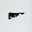

Label: airplane


In [3]:
# let's check the first image and its label

from IPython.display import display

image, label = train_dataset[1]
image = transforms.ToPILImage()(image)
display(image)

class_names = list(train_dataset.class_to_idx.keys())
label_name = class_names[label]

print(f"Label: {label_name}")

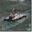

Label: ship


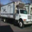

Label: truck


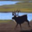

Label: deer


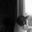

Label: cat


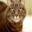

Label: cat


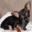

Label: dog


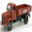

Label: truck


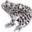

Label: frog


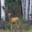

Label: deer


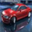

Label: automobile


In [4]:
data_iter = iter(cifar_train_loader)
images, labels = next(data_iter)
for i in range(10):
    image = transforms.ToPILImage()(images[i])
    display(image)
    print(f"Label: {class_names[labels[i]]}")

## 2. Build the Initial Transformers Model

The TransformerBlock class is a self-implemented version of a basic Transformer encoder layer. It includes multi-head self-attention, followed by a position-wise feed-forward network. Layer normalization and residual connections are used to stabilize training and allow better gradient flow.

Key components:
1. Multi-head Attention: We split the input into multiple attention heads, compute scaled dot-product attention for each, and concatenate them.
2. Feed-Forward Network: Two linear layers with a ReLU activation in between.
3. Layer Normalization and Residual Connections: Applied before and after the attention and feed-forward layers.
4. The forward pass takes an input tensor of shape [B, T, D] and outputs the same shape after applying attention and transformation.

In [5]:
import torch.nn as nn

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=4, ff_hidden=512, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.dim = dim
        self.scale = (dim // heads) ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.out_proj = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)
        self.ln1 = nn.LayerNorm(dim)
        self.ln2 = nn.LayerNorm(dim)

        self.ff = nn.Sequential(
            nn.Linear(dim, ff_hidden),
            nn.ReLU(),
            nn.Linear(ff_hidden, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B, T, D = x.shape
        qkv = self.qkv(x).reshape(B, T, 3, self.heads, D // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn_scores = (q @ k.transpose(-2, -1)) * self.scale
        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_out = attn_probs @ v
        attn_out = attn_out.transpose(1, 2).reshape(B, T, D)

        x = x + self.dropout(self.out_proj(attn_out))
        x = self.ln1(x)

        x = x + self.ff(x)
        x = self.ln2(x)S
        return x

In [6]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=96, embed_dim=256, num_blocks=2, num_classes=10):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, embed_dim)
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(embed_dim) for _ in range(num_blocks)]
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = x.permute(0, 2, 3, 1).reshape(B, 32, -1)
        x = self.input_proj(x)                       
        x = self.transformer_blocks(x)               
        x = x.transpose(1, 2)                        
        x = self.pool(x).squeeze(-1)                 
        return self.fc(x)

In [7]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            running_loss += loss.item() * x.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(y).sum().item()
            total += y.size(0)

    return running_loss / total, correct / total

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, cifar_train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, cifar_test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

Epoch 1/10 | Train Loss: 1.8121 Acc: 0.3320 | Test Loss: 1.7236 Acc: 0.3776
Epoch 2/10 | Train Loss: 1.6072 Acc: 0.4207 | Test Loss: 1.6010 Acc: 0.4144
Epoch 3/10 | Train Loss: 1.5342 Acc: 0.4474 | Test Loss: 1.4995 Acc: 0.4572
Epoch 4/10 | Train Loss: 1.4901 Acc: 0.4638 | Test Loss: 1.4955 Acc: 0.4607
Epoch 5/10 | Train Loss: 1.4528 Acc: 0.4791 | Test Loss: 1.4588 Acc: 0.4729
Epoch 6/10 | Train Loss: 1.4215 Acc: 0.4901 | Test Loss: 1.4433 Acc: 0.4774
Epoch 7/10 | Train Loss: 1.4057 Acc: 0.4962 | Test Loss: 1.4651 Acc: 0.4786
Epoch 8/10 | Train Loss: 1.3846 Acc: 0.5050 | Test Loss: 1.4003 Acc: 0.5013
Epoch 9/10 | Train Loss: 1.3653 Acc: 0.5068 | Test Loss: 1.4603 Acc: 0.4767
Epoch 10/10 | Train Loss: 1.3483 Acc: 0.5162 | Test Loss: 1.4133 Acc: 0.4864


Before modifying input_dim or embed_dim, we trained the baseline Transformer model for 10 epochs using:
1. input_dim = 96 (flattened image row)
2. embed_dim = 256
3. num_blocks = 2
4. Optimizer: Adam, LR = 1e-3

Performance Summary

1. epoch 1 -> 37.13% (test)
2. epoch 5 -> 47.70% (test)
3. epoch 10 -> 47.89% (test)

Training accuracy increased steadily, reaching over 51% in 10 epochs. Test accuracy plateaued around ~47–48%, indicating potential underfitting or capacity limit. No signs of severe overfitting yet → regularization not needed at this stage.

## 3. Model Experiment Testing

We aim to investigate the effect of changing key model parameters, such as:

1. Varying the number of neurons (embedding dimensions)
2. Increasing the number of Transformer layers

These changes will help us understand how model capacity influences training dynamics and performance.

#### 1. Varying the number of neurons (embedding the dimensions)

In [10]:
embed_dims = [64, 128, 256, 512, 768]

for emb in embed_dims:
    print(f"Training for embedding dimension = {emb}")
    model = TransformerClassifier(embed_dim = emb).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    epochs = 10
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, cifar_train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, cifar_test_loader, criterion, device)
    
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

Training for embedding dimension = 64
Epoch 1/10 | Train Loss: 1.7854 Acc: 0.3409 | Test Loss: 1.5560 Acc: 0.4328
Epoch 2/10 | Train Loss: 1.5477 Acc: 0.4427 | Test Loss: 1.4638 Acc: 0.4717
Epoch 3/10 | Train Loss: 1.4495 Acc: 0.4780 | Test Loss: 1.4169 Acc: 0.4870
Epoch 4/10 | Train Loss: 1.3812 Acc: 0.5071 | Test Loss: 1.3917 Acc: 0.4967
Epoch 5/10 | Train Loss: 1.3335 Acc: 0.5226 | Test Loss: 1.3586 Acc: 0.5075
Epoch 6/10 | Train Loss: 1.2816 Acc: 0.5426 | Test Loss: 1.2849 Acc: 0.5428
Epoch 7/10 | Train Loss: 1.2365 Acc: 0.5567 | Test Loss: 1.3291 Acc: 0.5316
Epoch 8/10 | Train Loss: 1.2030 Acc: 0.5679 | Test Loss: 1.2972 Acc: 0.5415
Epoch 9/10 | Train Loss: 1.1621 Acc: 0.5841 | Test Loss: 1.2656 Acc: 0.5499
Epoch 10/10 | Train Loss: 1.1314 Acc: 0.5970 | Test Loss: 1.2449 Acc: 0.5548
Training for embedding dimension = 128
Epoch 1/10 | Train Loss: 1.7648 Acc: 0.3494 | Test Loss: 1.5778 Acc: 0.4339
Epoch 2/10 | Train Loss: 1.5264 Acc: 0.4475 | Test Loss: 1.4776 Acc: 0.4587
Epoch 3/10

#### 2. Increasing the number of Tranformer Layers

In [11]:
for L in [1,2,3,4]:
    print(f"Training for block numbers = {L}")
    model = TransformerClassifier(embed_dim = 64, num_blocks = L).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    epochs = 10
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, cifar_train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, cifar_test_loader, criterion, device)
    
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")
        print("\n")

Training for block numbers = 1
Epoch 1/10 | Train Loss: 1.8501 Acc: 0.3173 | Test Loss: 1.6498 Acc: 0.3959


Epoch 2/10 | Train Loss: 1.6263 Acc: 0.4096 | Test Loss: 1.5569 Acc: 0.4322


Epoch 3/10 | Train Loss: 1.5349 Acc: 0.4470 | Test Loss: 1.5745 Acc: 0.4312


Epoch 4/10 | Train Loss: 1.4770 Acc: 0.4718 | Test Loss: 1.4577 Acc: 0.4756


Epoch 5/10 | Train Loss: 1.4346 Acc: 0.4858 | Test Loss: 1.4434 Acc: 0.4869


Epoch 6/10 | Train Loss: 1.3925 Acc: 0.5003 | Test Loss: 1.4329 Acc: 0.4858


Epoch 7/10 | Train Loss: 1.3614 Acc: 0.5153 | Test Loss: 1.4240 Acc: 0.4899


Epoch 8/10 | Train Loss: 1.3349 Acc: 0.5221 | Test Loss: 1.3598 Acc: 0.5141


Epoch 9/10 | Train Loss: 1.3030 Acc: 0.5349 | Test Loss: 1.3895 Acc: 0.5064


Epoch 10/10 | Train Loss: 1.2791 Acc: 0.5420 | Test Loss: 1.3586 Acc: 0.5142


Training for block numbers = 2
Epoch 1/10 | Train Loss: 1.8085 Acc: 0.3327 | Test Loss: 1.6666 Acc: 0.4067


Epoch 2/10 | Train Loss: 1.5542 Acc: 0.4365 | Test Loss: 1.5193 Acc: 0.4516


E

These results show that adding more layers improves both training and test accuracy up to a certain point. The best performance was achieved with 4 blocks, suggesting that deeper Transformer models can extract more meaningful relationships across image rows.

However, the gains start to plateau around 3–4 layers, and going even deeper might require additional regularization (e.g., dropout or layer norm tuning) to avoid overfitting or diminishing returns. Hence, above is the best model that can be gained using transformers.

## 4. Conclusion

In this project, we explored and compared different sequence-based neural architectures, a custom-built Transformer for image classification, and compared it with an RNN that I wrote in the previous code. Each image was treated as a sequence of 32 rows, with each row flattened into a 96-dimensional vector. Our goal was to analyze how each model processes sequences, how performance changes with different configurations, and how Transformers differ in their fundamental mechanisms.

We found that Transformers, while originally designed for NLP, can perform surprisingly well on image data when the input is structured as a sequence. Although the baseline Transformer model started with modest performance, it quickly outperformed RNNs after appropriate tuning. Specifically, the best results were achieved using a small embedding size (64) and 2–3 Transformer layers, showing that even lightweight attention-based models can generalize well on datasets like CIFAR-10.

Throughout the experiments, we observed that the self-attention mechanism is the most critical differentiator between Transformers and traditional RNNs. While RNNs rely on sequential processing and hidden states, Transformers process all tokens in parallel and allow each token to dynamically "attend" to others using Query, Key, and Value matrices. This gives Transformers a global view of the sequence, enabling them to model long-range dependencies more effectively.

In conclusion, although Transformers require more compute and careful tuning, they offer a more powerful and flexible alternative to RNNs — even in image classification tasks. The attention mechanism allows for better context understanding, faster convergence, and higher accuracy when applied correctly.

But as you know, you may also explore ViT (Vision Transformers), which gives you a higher result in the testing, but it is out of the scope of the assignment. Hence, 58% as the final result for the Vanilla Transformers honestly satisfied us already.